In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
import scipy.signal as sig
import numpy as np
import pandas as pd
import logging
import os
import os.path
from IPython.core.debugger import set_trace

In [2]:
class dummy():
    pass

In [3]:
def set_step_size(new_step_size, invoke_updater=True):
    'sets self.step_size'
    if new_step_size<=0:
        self.logger.warning('Step size must be larger than zero')
    else:
        new_step_size=1/np.floor(1/new_step_size)
        if self.step_size!=new_step_size:
            self.step_size=new_step_size
            if invoke_updater:
                updater('step_size')
    return self.step_size

In [4]:
def set_wavelength_range(new_range=None, invoke_updater=True):
    '''sets self.wavelength_range
    
    If new_range=None it uses self.piezo_wl_tuning_range adds a margin on both side
    
    @param new_range: new wavelength range
    @type new_range: [int,int]
    '''
    if new_range==None:
        margin=50
        new_range=np.copy(self.piezo_tuning_dict['wl_range'])
        new_range[0]-=margin
        new_range[1]+=margin

    new_range=np.asarray(new_range)
    if np.alltrue(new_range>0) and (new_range[1]>new_range[0]):
        self.wavelength_range=new_range[0:2]
        if invoke_updater:
            updater('wavelength_range')
    else:
        self.logger.warning('wavelength range has wrong format')
    return self.wavelength_range

In [5]:
def calculate_number_of_steps():
    self.number_of_steps=int(np.ptp(self.wavelength_range)/self.step_size)

In [6]:
def init_spectrum_df():
    'init of the spectrum data frame'
    indexes=[('x_axes','wavelength'),('y_axes','sum_absorbance')]
    index=pd.MultiIndex.from_tuples(indexes, names=['axis', 'type'])
    self.spectrum_df=pd.DataFrame(columns=index)
    self.spectrum_df['x_axes','wavelength']=np.linspace(self.wavelength_range[0],self.wavelength_range[1],self.number_of_steps)
    self.spectrum_df['y_axes','sum_absorbance']=np.zeros(self.number_of_steps)
    self.spectrum_df['y_axes','power']=np.zeros(self.number_of_steps)

In [7]:
def update_cavity_length_axis():
    self.spectrum_df['x_axes','cavity_length']=self.spectrum_df['x_axes','wavelength']*self.mode_number/1000
    #sorting columns
    self.spectrum_df.sort_index(axis=1,inplace=True)

In [8]:
def load_PNNL_data():
    '''
    loads the PNNL absorbance data from the files given in self.simulation_data'''
    #loads the PNNL spectra from file and interpolates and convolves the absorption data
    Wavenumber_range=10**9/(self.wavelength_range[::-1]*100)
    number_of_steps=int(np.ptp(self.wavelength_range)/self.step_size)
    for index, row in self.simulation_data.iterrows():
        #load data from file
        try:
            PNNL_spectr=pd.read_csv(row['spectrum'], sep='\t',header=None,names=['wavenumber','absorbance'])
        except:
            self.logger.error('Not able to load file: '+row['spectrum'])
            pass

        #generate Wavelenghts
        PNNL_spectr['wavelength']=1.0/(PNNL_spectr['wavenumber']*100)*10**9
        
        #interpolate absorbances
        
        self.spectrum_df['y_axes',index]=np.interp(self.spectrum_df['x_axes','wavelength'],PNNL_spectr['wavelength'],PNNL_spectr['absorbance'])

        #sorting columns
        self.spectrum_df.sort_index(axis=1,inplace=True)



In [9]:
def set_lineshape_convolution_method(method=None,FWHM=None,nr_shapes=None, lineshape_file=None, invoke_updater=True):
    '''
    sets the lineshape convolution parameters
    
    @param method: 'Gaussian' or 'Lorenzian' for synthetic lineshapes or 'laser' for a measured lineshape
                    'None' for delta_function
    @param FWHM_range: Only aplicable if method !file. Linewidhts to use.
    @type  FWHM_range:  double if nr_shapes=1
                        list or np.array of tw doubles if nr_shapes>1
    @param nr_shapes: nr of lineshapes
    @param lineshape_file: file path of the measured lineshape file
    '''
    method_list=['Gaussian', 'Lorentzian', 'None','Laser']
    update_needed=False
    if method!=None:
        if method in method_list:
            if self.lineshape_convolution_dict['method']!=method:
                self.lineshape_convolution_dict['method']=method
                update_needed=True
        else:
            self.logger.warning('convolution method must be one of '+str(method_list))
            
    if FWHM!=None:
        FWHM=np.ndarray.astype(np.atleast_1d(FWHM),np.float16)
        if np.all(FWHM>0):
            if not np.array_equal(self.lineshape_convolution_dict['FWHM'],FWHM):
                self.lineshape_convolution_dict['FWHM']=FWHM
                update_needed=True
        else:
            self.logger.warning('FWHM must be larger than zero')
    if nr_shapes!=None:
        if nr_shapes>0:
            if self.lineshape_convolution_dict['nr_shapes']!=nr_shapes:
                self.lineshape_convolution_dict['nr_shapes']=nr_shapes
                update_needed=True
        else:
            self.logger.warning('Number of shapes must be larger than zero')
    if lineshape_file!=None:
        if os.path.isfile(lineshape_file) :
            if self.lineshape_convolution_dict['lineshape_file']!=lineshape_file:
                self.lineshape_convolution_dict['lineshape_file']=lineshape_file
                update_needed=True
        else:
            self.logger.warning('Lineshape file not found: '+lineshape_file)
    if update_needed & invoke_updater:
        updater('lineshape_convolution_dict')
            

In [10]:
def generate_lineshapes(invoke_updater=True):
    '''
    generates lineshapes
     
    If nr_shapes>2, the widths are linealry interpolated between in given values in FWHM_range
    '''
    method=self.lineshape_convolution_dict['method']
    FWHM=self.lineshape_convolution_dict['FWHM']
    nr_shapes=self.lineshape_convolution_dict['nr_shapes']
    
    if method=='Laser':
        generate_lineshapes_from_file()
    else:
        if FWHM.shape[0]==1:
            FWHM_array=np.repeat(FWHM[0],nr_shapes)
        if FWHM.shape[0]==2:
            FWHM_array=np.linspace(FWHM[0],FWHM[1],nr_shapes)

        x_array_range=FWHM_array.max()/2*10
        x_array_steps=int(2*x_array_range/self.step_size)
        if x_array_steps%2==0:
            #make shure that x__array_steps is odd (to have a point at 0 in x_array)
            x_array_steps+=1
        x_array=np.linspace(-x_array_range,x_array_range,x_array_steps)


        self.lineshapes=np.empty([nr_shapes,x_array.shape[0]])


        for idx in range(nr_shapes):
            if method=='Gaussian':
                std=FWHM_array[idx]/(2*np.sqrt(2*np.log(2)))
                norm=scipy.stats.norm(loc=0,scale=std)
                self.lineshapes[idx,:]=norm.pdf(x_array)*self.step_size #division by step_size needed for normalisation
            elif method=='Lorentzian':
                gamma=FWHM_array[idx]/2
                cauchy=scipy.stats.cauchy(loc=0,scale=gamma)
                self.lineshapes[idx,:]=cauchy.pdf(x_array)*self.step_size #division by step_size needed for normalisation
            elif method=='None':
                delta=np.zeros(x_array.shape[0])
                zero_position=np.argmin(x_array)
                delta[np.argmin(abs(x_array))]=1 #set zentral point to 1
                self.lineshapes[idx,:]=delta
    if invoke_updater:    
        updater('lineshapes')


    

In [11]:
def calculate_lineshape_convolution():
    '''
    convolves the PNNL spectra with the lineshapes given in self.lineshapes
    It uses the overlap-add method. If more than one lineshape is given in self.lineshapes, is segmented 
    in N(lineshapes) and for each segment (ordered from low to high wavelength) a particular lineshape is 
    used as a convolution kernel. 
    '''
    def convolve(data):
        'convolution according to the overlap-add method'
        L = self.spectrum_df['x_axes','wavelength'].shape[0]  # length of input signal
        N = self.lineshapes.shape[1]  # length of impulse response
        P = L/self.lineshapes.shape[0]  # length of segments

        xp = np.zeros((L//P, P))     #segment to convolve
        yp = np.zeros((L//P, N+P-1)) #convolution of segment with kernel
        convolution = np.zeros(L+P-1)
        
        for n in range(L//P):
            kernel=self.lineshapes[n]
            xp[n, :] = data[n*P:(n+1)*P]
            yp[n, :] = np.convolve(xp[n,:], kernel, mode='full')
            convolution[n*P:(n+1)*P+N-1] += yp[n, :]
        convolution = convolution[N/2:L+N/2]
        return convolution
    for key in self.simulation_data.index:
        try:
            convolution=convolve(self.spectrum_df['y_axes',key])
        except:
            self.logger.error('Lineshape convolution not possible. Change parameters')
        else:
            self.spectrum_df['y_axes',key+'_conv']=convolution

In [12]:
def generate_lineshapes_from_file():
    '''
    generates the lineshapes from a lineshape file
    It takes the lineshape in the file and interpolates and normalises them.
    '''
    path=self.lineshape_convolution_dict['lineshape_file']
    basename=os.path.basename(path)
    ext=basename.split('.')[-1]
    nr_shapes=self.lineshape_convolution_dict['nr_shapes']
    if ext=='pck':
        #load data from a saved pickle lineshape file
        lineshapes_from_file=pd.read_pickle(path)
        #list of wavelengths in file (wavelengths at which a lineshape is available)
        wavelengths=np.asarray(map(float,lineshapes_from_file.columns[1:]))
        #list of fourier wavelengths (means relative wavelength with respect to line center)
        fourier_wavelengths=lineshapes_from_file['wavelength'].values

        #array of lineshape data
        values=np.asarray(lineshapes_from_file.values)[:,1:]
        #2D interpolation function
        interp_func=scipy.interpolate.interp2d(wavelengths,fourier_wavelengths,values,kind='linear') 
        
        # fourier_wavelengts_to_interpolate contains the fourier wavelengths at which the lineshapes are interpolated
        x_array_range=1./2*10 # range is +-5nm
        x_array_steps=int(2*x_array_range/self.step_size)
        if x_array_steps%2==0:
            #make shure that x__array_steps is odd (to have a point at 0 in x_array)
            x_array_steps+=1
        fourier_wavelengths_to_interpolate=np.linspace(-x_array_range,x_array_range,x_array_steps)
        
        # wavelengts_to_interpolate contains the wavelengths at which the lineshapes are interpolated
        if nr_shapes==1:
            #take mean of wavelength range
            wavelengths_to_interpolate=self.wavelength_range.mean()
        else:
            wavelengths_to_interpolate=np.linspace(self.wavelength_range[0],self.wavelength_range[1],nr_shapes)
        #interpolation of the lineshapes
        try:
            self.lineshapes=interp_func(wavelengths_to_interpolate,fourier_wavelengths_to_interpolate).T
        except:
            self.logger.error('Error in laser lineshape interpolation')
        else:   
            #normalisation
            self.lineshapes/=np.atleast_2d(np.sum(self.lineshapes,axis=1)).T

        

In [13]:
def caculate_lineshape_convolution():
    '''
    convolves the PNNL spectra with the lineshapes given in self.lineshapes
    It uses the overlap-add method. If more than one lineshape is given in self.lineshapes, is segmented 
    in N(lineshapes) and for each segment (ordered from low to high wavelength) a particular lineshape is 
    used as a convolution kernel. 
    '''
    def convolve(data):
        'convolution according to the overlap-add method'
        L = self.spectrum_df['x_axes','wavelength'].shape[0]  # length of input signal
        N = self.lineshapes.shape[1]  # length of impulse response
        P = L/self.lineshapes.shape[0]  # length of segments

        xp = np.zeros((L//P, P))     #segment to convolve
        yp = np.zeros((L//P, N+P-1)) #convolution of segment with kernel
        convolution = np.zeros(L+P-1)
        
        for n in range(L//P):
            kernel=self.lineshapes[n]
            xp[n, :] = data[n*P:(n+1)*P]
            yp[n, :] = np.convolve(xp[n,:], kernel, mode='full')
            convolution[n*P:(n+1)*P+N-1] += yp[n, :]
        convolution = convolution[N/2:L+N/2]
        return convolution
    for key in self.simulation_data.index:
        try:
            convolution=convolve(self.spectrum_df['y_axes',key])
        except:
            self.logger.error('Lineshape convolution not possible. Change parameters')
        else:
            self.spectrum_df['y_axes',key+'_conv']=convolution
        



In [14]:
def set_concentrations(component, new_conc, invoke_updater=True):
    #sets concentration of component to conc [ppm]
    set_conc=-1
    if new_conc <0:
        self.logger.warning('concentration must be larger than zero')
    else: 
        if component in self.simulation_data.index:
            if self.simulation_data.loc[component,'concentrations']!=new_conc:
                self.simulation_data.loc[component,'concentrations']=new_conc
                if invoke_updater:
                    updater('concentrations')
            set_conc=new_conc
        else:
            self.logger.warning('Wrong component: '+component)
    return set_conc
        

In [15]:
def set_cell_length(new_length, invoke_updater=True):
    if new_length<0:
        self.logger.warning('cell length must be >= zero')
    else:
        self.cell_length=new_length
        if invoke_updater:
            updater('concentrations')

In [16]:
def calculate_sum_absorbance():
    #calculates the sum of the absorbance of all components
    sum_absorbance=np.zeros([self.spectrum_df['x_axes','wavelength'].shape[0]])
    for component in self.simulation_data.index:
        if (component+'_conv') in self.spectrum_df['y_axes']:
            sum_absorbance+=self.spectrum_df['y_axes',component+'_conv']*self.simulation_data.loc[component,'concentrations']
    self.spectrum_df['y_axes','sum_absorbance']=sum_absorbance
        

In [17]:
def set_cavity_length(new_length,invoke_updater=True):
    '''
    sets the cavity length of the laser and calculates the caity mode number
    cavity_length is in um, wavelength in nm
    @param new_length: cavity length in um
    @type new_length: double
    '''
    if new_length*1000<=self.wavelength_range.max():
        self.logger.warning('Cavity length must be larger than wavelength')
    else:
        self.cavity_length=new_length
        self.mode_number=np.floor(new_length*1000*2.0/self.wavelength_range.mean())/2.0
        if invoke_updater:
            updater('cavity_length')
    return self.cavity_length


In [18]:
def set_piezo_tuning_method(method=None,hysteresis_param=None,wl_range=None,v_range=None,nr_steps=None,tuning_file=None,invoke_updater=True):
    '''
    sets the piezo tuning parameters
    
    @param method: 'linear' or 'hysteresis' for synthetic tunings or 'laser'for a measured tuning
    @param hysteresis_parameter: Only aplicable if method hysteresis. hysteresis to use.
    @param wl_range: wavelength tuning range
    @type wl_range: np.array[(double,double)]
    @param v_range: voltage tuning range
    @type v_range: np.array[(double,double)]
    @param nr_steps: number of steps
    @type nr_steps: int
    @param tuning_file: file path of the measured tuning file
    '''
    method_list=['linear', 'hysteresis','Laser']
    update_needed=False
    if method!=None:
        if method in method_list:
            if self.piezo_tuning_dict['method']!=method:
                self.piezo_tuning_dict['method']=method
                update_needed=True
        else:
            self.logger.warning('Piezo tuning method must be one of '+str(method_list))
            
    if hysteresis_param!=None:
        if hysteresis_param>=0:
            if self.piezo_tuning_dict['hysteresis_param']!=hysteresis_param:
                self.piezo_tuning_dict['hysteresis_param']=hysteresis_param
                update_needed=True
        else:
            self.logger.warning('Hysteresis parameter must be >= zero')
    if tuning_file!=None:
        if os.path.isfile(tuning_file) :
            if self.piezo_tuning_dict['tuning_file']!=tuning_file:
                self.piezo_tuning_dict['tuning_file']=tuning_file
                update_needed=True
        else:
            self.logger.warning('Piezo tuning file not found: '+lineshape_file)
            
    if isinstance(wl_range,(np.ndarray,list)):
        wl_range=np.asarray(wl_range)
        if np.all(wl_range>0) and (wl_range.ptp()>0):
            if ~np.array_equal(self.piezo_tuning_dict['wl_range'],wl_range):
                self.piezo_tuning_dict['wl_range']=wl_range
                update_needed=True
        else:
            self.logger.warning('Piezo tuning range must be larger than zero')
    
    if isinstance(v_range,(np.ndarray,list)):
        v_range=np.asarray(v_range)
        if np.all(v_range>=0) and (v_range.ptp()>0):
            if ~np.array_equal(self.piezo_tuning_dict['v_range'],v_range):
                self.piezo_tuning_dict['v_range']=v_range
                update_needed=True
        else:
            self.logger.warning('Piezo tuning range must be larger than zero')
    if nr_steps!=None:
        if nr_steps>1:
            if self.piezo_tuning_dict['nr_steps']!=int(nr_steps):
                self.piezo_tuning_dict['nr_steps']=int(nr_steps)
                update_needed=True
        else:
            self.logger.warning('Piezo tuning range must be larger than zero')
    
            
    
        
        
    if update_needed and invoke_updater:
        updater('piezo_tuning_dict')

In [19]:
def calculate_piezo_tuning_curve():
    '''
    calculates the piezo tuning curve using the parameters in self.piezo_tuning_dict
    
    '''
    v_range=self.piezo_tuning_dict['v_range']
    wl_range=self.piezo_tuning_dict['wl_range']
    
    #get wavelengths
    if self.piezo_tuning_dict['method']=='linear':
        wl_array=np.linspace(wl_range[0],wl_range[1],self.piezo_tuning_dict['nr_steps'])
        wl_array_scaled=wl_array
    elif self.piezo_tuning_dict['method']=='hysteresis':
        
        wl_array=0.5*(1+scipy.special.erf(np.linspace(-1,1,self.piezo_tuning_dict['nr_steps'])/(self.piezo_tuning_dict['hysteresis_param']*np.sqrt(2))))
        #scale to wl_x_array
        wl_array_scaled=wl_array/wl_array.ptp()*wl_range.ptp()
        wl_array_scaled-=wl_array_scaled[0]-wl_range[0]
    
    #piezo voltages
    v_array=np.linspace(v_range[0],v_range[1],self.piezo_tuning_dict['nr_steps'])

    #set piezo step voltages in self.spectrum_df

    v_array_for_spectrum_df=np.empty((self.number_of_steps))
    v_array_for_spectrum_df[:]=np.NaN
    self.spectrum_df['x_axes','piezo_v']=v_array_for_spectrum_df
    self.spectrum_df['x_axes','piezo_v_drifted']=v_array_for_spectrum_df

    def find_closest_idx(A, target):
        #finds the index of the element in A closest to target
        #from http://stackoverflow.com/questions/8914491/finding-the-nearest-value-and-return-the-index-of-array-in-python
        idx = A.searchsorted(target)
        idx = np.clip(idx, 1, len(A)-1)
        left = A[idx-1]
        right = A[idx]
        idx -= target - left < right - target
        return idx

    indexes=find_closest_idx(self.spectrum_df['x_axes','wavelength'].values,wl_array_scaled)
    self.spectrum_df['x_axes','piezo_v'].iloc[indexes]=v_array
    self.spectrum_df['x_axes','piezo_v_drifted'].iloc[indexes]=v_array

    #theoretical piezo voltages for all wavelengths in range
    v_array_for_spectrum_df=np.empty((self.number_of_steps))
    v_array_for_spectrum_df[:]=np.NaN

    number_of_wl_in_range=((self.spectrum_df['x_axes','wavelength']>=wl_range[0]) & (self.spectrum_df['x_axes','wavelength']<=wl_range[1])).values.sum()
    if self.piezo_tuning_dict['method']=='linear':
        piezo_v_all_array=np.linspace(-1,1,number_of_wl_in_range)
    elif self.piezo_tuning_dict['method']=='hysteresis': 
        piezo_v_all_array=scipy.special.erfinv(2*np.linspace(wl_array.min(),wl_array.max(),number_of_wl_in_range)-1)
        
    piezo_v_all_array/=piezo_v_all_array.ptp()/v_range.ptp()
    piezo_v_all_array-=piezo_v_all_array[0]-v_range[0]

    start_index=self.spectrum_df['x_axes','wavelength'][self.spectrum_df['x_axes','wavelength']>=wl_range[0]].index[0]

    v_array_for_spectrum_df[start_index:start_index+number_of_wl_in_range]=piezo_v_all_array
    self.spectrum_df['x_axes','piezo_v_all']=v_array_for_spectrum_df
    self.spectrum_df['x_axes','piezo_v_all_drifted']=v_array_for_spectrum_df
    
     
    
        

In [20]:
def plot_piezo_tuning_curve(ax=None,drifted=False):
    '''plots the piezo tuning curve
    @param ax: axis to plot the curve. If 'None' a new fig is generated
    @param drifted: If the the drifting tuning curve is shown
    '''
    if drifted:
        x_array_all=self.spectrum_df['x_axes','piezo_v_all_drifted']
        x_array_measured=self.spectrum_df['x_axes','piezo_v_drifted']
    else:
        x_array_all=self.spectrum_df['x_axes','piezo_v_all']
        x_array_measured=self.spectrum_df['x_axes','piezo_v']

    x_array_all_filtered=x_array_all[x_array_all.notnull()]
    y_array_all=self.spectrum_df['x_axes','wavelength'][x_array_all.notnull()]


    x_array_measured_filtered=x_array_measured[x_array_measured.notnull()]
    y_array_measured=self.spectrum_df['x_axes','wavelength'][x_array_measured.notnull()]
    if ax==None:
        fig, ax=plt.subplots(1)
    ax.plot(x_array_all_filtered,y_array_all,label='all points')
    ax.plot(x_array_measured_filtered,y_array_measured,color='r',linestyle='',marker='.',label='measured points')
    ax.set_xlabel('Piezo voltage / V')
    ax.set_ylabel('Wavelength / nm')
    set_plot_limits2(ax,'x')
    set_plot_limits2(ax,'y')
    ax.legend(loc=0)

In [21]:
def set_power_spectrum_method(method=None,wl_range=None,steepnes=None,max_power=None,power_file=None,invoke_updater=True):
    '''
    sets the piezo tuning parameters
    
    @param method: 'linear' or 'hysteresis' for synthetic tunings or 'laser'for a measured tuning
    @param steepnes: Only aplicable if method box. edge steepnes to use.
    @param wl_range: wavelength tuning range
    @type wl_range: np.array[(double,double)]
    @param tuning_file: file path of the measured power file
    '''
    method_list=['constant', 'box','Laser']
    update_needed=False
    if method!=None:
        if method in method_list:
            if self.power_spectrum_dict['method']!=method:
                self.power_spectrum_dict['method']=method
                update_needed=True
        else:
            self.logger.warning('Power spectrum method must be one of '+str(method_list))
            
    if max_power!=None:
        if max_power>=0:
            if self.power_spectrum_dict['max_power']!=np.float32(max_power):
                self.power_spectrum_dict['max_power']=np.float32(max_power)
                update_needed=True
        else:
            self.logger.warning('max power parameter must be >= zero')
    
    if steepnes!=None:
        if steepnes>=0:
            if self.power_spectrum_dict['steepnes']!=np.float32(steepnes):
                self.power_spectrum_dict['steepnes']=np.float32(steepnes)
                update_needed=True
        else:
            self.logger.warning('steepnes parameter must be >= zero')
    
    if power_file!=None:
        if os.path.isfile(power_file) :
            if self.power_spectrum_dict['power_file']!=power_file:
                self.power_spectrum_dict['power_file']=power_file
                update_needed=True
        else:
            self.logger.warning('Power file file not found: '+power_file)
            
    if isinstance(wl_range,(np.ndarray,list)):
        wl_range=np.asarray(wl_range)
        if np.all(wl_range>0) and (wl_range.ptp()>0):
            if ~np.array_equal(self.power_spectrum_dict['wl_range'],wl_range):
                self.power_spectrum_dict['wl_range']=wl_range
                update_needed=True
        else:
            self.logger.warning('Power range must be larger than zero')

    if update_needed and invoke_updater:
        updater('power_spectrum_dict')

In [22]:
def calculate_power_spectrum():
    '''
    calculates the power output spectrum of the laser using the parameters in self.power_spectrum_dict
    '''
    wl_range=self.power_spectrum_dict['wl_range']
    steepnes=self.power_spectrum_dict['steepnes']
    method=self.power_spectrum_dict['method']
    max_power=self.power_spectrum_dict['max_power']
    
    if method=='box':
        def erf(x,x_0,steepnes):
            return 0.5*(1+scipy.special.erf((x-x_0)/(steepnes*np.sqrt(2))))
        self.spectrum_df['y_axes','power']=erf(self.spectrum_df['x_axes','wavelength'],wl_range[0],steepnes)-erf(self.spectrum_df['x_axes','wavelength'],wl_range[1],steepnes)
    elif method=='constant':
        self.spectrum_df['y_axes','power']
        
    self.spectrum_df['y_axes','power']*=max_power
    

In [23]:
def calculate_transmission_spectrum():
    '''
    calculates the transmission spectrum
    transmission 1 is the sample channel
    transmission 2 is the reference channel
    '''
    self.spectrum_df['y_axes','transmission_1']=self.spectrum_df['y_axes','power']/(10**(self.spectrum_df['y_axes','sum_absorbance']*self.cell_length))
    self.spectrum_df['y_axes','transmission_2']=self.spectrum_df['y_axes','power']

In [24]:
def calculate_noise():
    '''
    calculates noise on the measurement channels using the parameters in self.noise_dict
    '''
    laser_noise_method=self.noise_dict['laser_noise_method']
    laser_noise_file=self.noise_dict['laser_noise_file']
    laser_noise_rsd=self.noise_dict['laser_noise_rsd']
    detector_noise_sd=self.noise_dict['detector_noise_sd']
    electronics_noise_sd=self.noise_dict['electronics_noise_sd']
    
    if laser_noise_method=='norm':
        laser_noise=np.random.normal(1.0,laser_noise_rsd/100,self.number_of_steps)
    elif laser_noise_method=='laser':
        #TODO: not yet implemented
        laser_noise=np.empty(self.number_of_steps)
        laser_noise[:]=1
    detector_noise=np.random.normal(0,detector_noise_sd,self.number_of_steps)
    electronics_noise=np.random.normal(0,electronics_noise_sd,self.number_of_steps)
    
    self.spectrum_df['y_axes','channel_1']=self.spectrum_df['y_axes','transmission_1']*laser_noise+detector_noise+electronics_noise
    #calculate new detector noise
    detector_noise=np.random.normal(0,detector_noise_sd,self.number_of_steps)
    #calculate new electronics noise
    electronics_noise=np.random.normal(0,electronics_noise_sd,self.number_of_steps)
    self.spectrum_df['y_axes','channel_2']=self.spectrum_df['y_axes','transmission_2']*laser_noise+detector_noise+electronics_noise
    

In [25]:
def calculate_drift(drift_time=0):
    '''
    calculates the actual drift in nm
    @param drift_time: time relative to start of measurements in s 
    @type drift_time: double
    '''

    drift_params=self.drift_dict['drift_params']
    def saturation(t,amplitude,decay):
        y=amplitude*(1-np.exp(-t/decay))
        return y
    def exponential(t,amplitude,decay):
        y=amplitude*np.exp(-t/decay)
        return y
    def generic(t,amplitude,decay):
        if amplitude>=0:
            y=saturation(t,amplitude,decay)
        else:
            y=exponential(t,amplitude,decay)
        return y

    s_per_day=3600*24
    drift_time_days=drift_time/s_per_day
    #constant offset
    drift=drift_params[0]
    #linear drift
    drift+=drift_time_days*drift_params[1]
    #fist exponential
    if (drift_params[2]>0) and (drift_params[3]>0):
        drift+=generic(drift_time_days,drift_params[3],1.0/drift_params[2])
    #second exponential
    if (drift_params[4]>0) and (drift_params[5]>0):
        drift+=generic(drift_time_days,drift_params[5],1.0/drift_params[4])
    return drift

In [116]:
def calculate_next_drift_step():
    '''
    calculates the drift using the parameters in self.drift_dict
    '''
    drift_params=self.drift_dict['drift_params']
    drift_enable=self.drift_dict['drift_enable']
    drift_time=self.drift_dict['drift_time']
    
    if drift_enable:
    
        if drift_time<0:
            #first measurement
            drift_time=0
        else:
            drift_time+=1.0/self.measurement_rate
        
        drift=calculate_drift(drift_time)

        #drift in simulation steps
        drift_in_steps=int(drift/(self.mode_number*self.step_size))
        #shift piezo x_axis
        #array=np.empty(self.number_of_steps+2*abs(drift_in_steps))
        #array[:]=np.NaN
        #array[abs(drift_in_steps):abs(drift_in_steps)+self.number_of_steps]=self.spectrum_df['x_axes','piezo_v'].values
        #self.spectrum_df['x_axes','piezo_v_drifted']=array[abs(drift_in_steps)+drift_in_steps:abs(drift_in_steps)+drift_in_steps+self.number_of_steps]
        self.spectrum_df['x_axes','piezo_v_drifted']=self.spectrum_df['x_axes','piezo_v'].shift(drift_in_steps)
        self.spectrum_df['x_axes','piezo_v_all_drifted']=self.spectrum_df['x_axes','piezo_v_all'].shift(drift_in_steps)

        

        #update drift time in dict
        self.drift_dict['drift_time']=drift_time
    

In [86]:
self.drift_dict['drift_time']=0

In [115]:
%timeit self.spectrum_df['x_axes','piezo_v_all_drifted']=self.spectrum_df['x_axes','piezo_v_all_drifted']

100 loops, best of 3: 12.1 ms per loop


In [110]:
%prun  self.spectrum_df['x_axes','piezo_v_all_drifted']=self.spectrum_df['x_axes','piezo_v'].shift(10)

In [117]:
def set_drift_parameters(drift_params=None,drift_enable=None,drift_time=None,invoke_updater=True):
    '''
    sets the drift parameters
    
    @param drift_params:    drift parameters:
                            drift_params[0]: constant ofset [nm]
                            drift_params[1]: linear drift rate [nm/d]
                            drift_params[2]: fast exponential decay rate [1/d]
                            drift_params[3]: fast exponential decay amplitude [nm]
                            drift_params[4]: slow exponential decay rate [1/d]
                            drift_params[5]: slow exponential decay amplitude [nm]
    
    @type drift_params: np.ndarray or list
    @param drift_enable: enables or disables drift
    @type drift_rate: bool
    @param drift_time: actual drift time in s
    @type drift_time: float
    '''
    update_needed=False
    
    if drift_params!=None:
        if isinstance(drift_params,(np.ndarray,list)):
            drift_params=np.asarray(drift_params)
            if np.all(np.isfinite(drift_params)):
                if ~np.array_equal(self.drift_dict['drift_params'],drift_params):
                    self.drift_dict['drift_params']=drift_params
                    update_needed=True
            else:
                self.logger.warning('drift_params are not finite or decay rates are negative') 
        else:
            self.logger.warning('drift_params must be np.ndarray or list')
        
    if drift_enable!=None:
        if isinstance(drift_enable,bool):
            if self.drift_dict['drift_enable']!=drift_enable:
                self.drift_dict['drift_enable']=drift_enable
                update_needed=True
        else:
            self.logger.warning('drift_enable parameter must be True or False')
    
    if drift_time!=None:
        if drift_time>=-1:
            if self.drift_dict['drift_time']!=np.float32(drift_time):
                self.drift_dict['drift_time']=np.float32(drift_time)
                update_needed=True
        else:
            self.logger.warning('drift_time parameter must be >= zero')
        
    if update_needed and invoke_updater:
        updater('drift_dict')

In [118]:
def set_noise_parameters(laser_noise_method=None,laser_noise_rsd=None,detector_noise_sd=None,electronics_noise_sd=None,laser_noise_file=None, invoke_updater=True):
    '''
    sets the piezo tuning parameters
    
    @param method: 'norm' for normal distributed nosis or 'laser'for a measured tuning
    @param laser_noise_rsd: Only aplicable if method norm. relative standard deviation in %
    @param detector_noise: Detector noise standard deviation in mV
    @param electronics_noise: Electronics noise standard deviation in mV
    @param nr_detector: nr of detectors to use
    '''
    method_list=['norm','Laser']
    update_needed=False
    if laser_noise_method!=None:
        if laser_noise_method in method_list:
            if self.noise_dict['method']!=laser_noise_method:
                self.noise_dict['method']=laser_noise_method
                update_needed=True
        else:
            self.logger.warning('Noise method must be one of '+str(method_list))
            
    if laser_noise_rsd!=None:
        if laser_noise_rsd>=0:
            if self.noise_dict['laser_noise_rsd']!=np.float32(laser_noise_rsd):
                self.noise_dict['laser_noise_rsd']=np.float32(laser_noise_rsd)
                update_needed=True
        else:
            self.logger.warning('Laser noise parameter must be >= zero')
    
    if detector_noise_sd!=None:
        if detector_noise_sd>=0:
            if self.noise_dict['detector_noise_sd']!=np.float32(detector_noise_sd):
                self.noise_dict['detector_noise_sd']=np.float32(detector_noise_sd)
                update_needed=True
        else:
            self.logger.warning('detector_noise parameter must be >= zero')
            
    if electronics_noise_sd!=None:
        if electronics_noise_sd>=0:
            if self.noise_dict['electronics_noise_sd']!=np.float32(electronics_noise_sd):
                self.noise_dict['electronics_noise_sd']=np.float32(electronics_noise_sd)
                update_needed=True
        else:
            self.logger.warning('electronics_noise parameter must be >= zero')
    
    if laser_noise_file!=None:
        if os.path.isfile(laser_noise_file) :
            if self.noise_dict['laser_noise_file']!=laser_noise_file:
                self.noise_dict['laser_noise_file']=laser_noise_file
                update_needed=True
        else:
            self.logger.warning('laser noise file not found: '+laser_noise_file)
            

    if update_needed and invoke_updater:
        updater('noise_dict')

In [119]:
def plot_absorbance_spectrum(ax=None,x_axis='wavelength'):
    '''plots the absorbance spectrum
    @param ax: axis to plot the curve. If 'None' a new fig is generated
    @param x_axis: which x_axis to use, either 'wavelength' or 'piezo'
    '''
    
    if x_axis=='wavelength':
        x_array_all=self.spectrum_df['x_axes','wavelength']
        y_array_all=self.spectrum_df['y_axes','sum_absorbance']

        second_axis_array=self.spectrum_df['x_axes','piezo_v_drifted']

        x_array_measured=self.spectrum_df['x_axes','wavelength']
        x_array_filtered=x_array_all[second_axis_array.notnull()]
        y_array_measured=self.spectrum_df['y_axes','sum_absorbance'][second_axis_array.notnull()]
    
    elif x_axis=='piezo':
        x_array_all=self.spectrum_df['x_axes','piezo_v_all_drifted']
        y_array_all=self.spectrum_df['y_axes','sum_absorbance']
        
        second_axis_array=self.spectrum_df['x_axes','wavelength']
        
        x_array_measured=self.spectrum_df['x_axes','piezo_v_drifted']
        x_array_filtered=x_array_all[x_array_measured.notnull()]
        y_array_measured=self.spectrum_df['y_axes','sum_absorbance'][x_array_measured.notnull()]
    
    
    if ax==None:
        fig, ax=plt.subplots(1)
    ax.plot(x_array_all,y_array_all,label='all points')
    ax.plot(x_array_filtered,y_array_measured,color='r',linestyle='',marker='.',markersize=5,label='measured points')
    ax_measured=ax.twiny()
    ax_measured.autoscale(enable=False,axis='y')
    ax_measured.plot(second_axis_array,linestyle='',marker='')
    if x_axis=='wavelength':
        ticks=self.spectrum_df['x_axes','piezo_v_all_drifted'][ax_measured.get_xticks()]
        ticks=['{:02.1f}'.format(label) for label in ticks]
        ax_measured.set_xticklabels(ticks)
        ax_measured.set_xlabel('Piezo voltage / V')
        ax.set_xlabel('Wavelength / nm')
    elif x_axis=='piezo':
        ticks=second_axis_array[ax_measured.get_xticks()]
        ticks=['{:02.1f}'.format(label) for label in ticks]
        ax_measured.set_xticklabels(ticks)
        ax_measured.set_xlabel('Wavelength / nm')
        ax.set_xlabel('Piezo voltage / V')
    set_plot_limits2(ax,'x')
    set_plot_limits2(ax,'y')
    ax.set_ylabel('Absorbance')
    ax.legend(loc=0)

In [120]:
def plot_channels(ax=None,x_axis='piezo',transmission=False):
    '''plots the absorbance spectrum
    @param ax: axis to plot the curve. If 'None' a new fig is generated
    @param x_axis: which x_axis to use, either 'wavelength' or 'piezo'
    @param transmission: If true the noise-less transmission spectrum is plotted
    '''
    
    if transmission:
        y_axis='transmission'
    else:
        y_axis='channel'
    
    if x_axis=='wavelength':


        second_axis_array=self.spectrum_df['x_axes','piezo_v_drifted']

        x_array_measured=self.spectrum_df['x_axes','wavelength']
        x_array_filtered=x_array_all[second_axis_array.notnull()]
        y_array_1_measured=self.spectrum_df['y_axes',y_axis+'_1'][second_axis_array.notnull()]
        y_array_2_measured=self.spectrum_df['y_axes',y_axis+'_2'][second_axis_array.notnull()]
    
    elif x_axis=='piezo':

        
        second_axis_array=self.spectrum_df['x_axes','wavelength']
        
        x_array_measured=self.spectrum_df['x_axes','piezo_v_drifted']
        x_array_filtered=x_array_measured[x_array_measured.notnull()]
        y_array_1_measured=self.spectrum_df['y_axes',y_axis+'_1'][x_array_measured.notnull()]
        y_array_2_measured=self.spectrum_df['y_axes',y_axis+'_2'][x_array_measured.notnull()]
    
    
    if ax==None:
        fig, ax=plt.subplots(1)
    ax.plot(x_array_filtered,y_array_1_measured,label='channel 1')
    ax.plot(x_array_filtered,y_array_2_measured,label='channel 2')
    ax_measured=ax.twiny()
    ax_measured.autoscale(enable=False,axis='y')
    ax_measured.plot(second_axis_array,linestyle='',marker='')
    if x_axis=='wavelength':
        ticks=self.spectrum_df['x_axes','piezo_v_all_drifted'][ax_measured.get_xticks()]
        ticks=['{:02.1f}'.format(label) for label in ticks]
        ax_measured.set_xticklabels(ticks)
        ax_measured.set_xlabel('Piezo voltage / V')
        ax.set_xlabel('Wavelength / nm')
    elif x_axis=='piezo':
        ticks=second_axis_array[ax_measured.get_xticks()]
        ticks=['{:02.1f}'.format(label) for label in ticks]
        ax_measured.set_xticklabels(ticks)
        ax_measured.set_xlabel('Wavelength / nm')
        ax.set_xlabel('Piezo voltage / V')
    set_plot_limits2(ax,'x')
    set_plot_limits2(ax,'y')
    
    ax.set_ylabel('Absorbance')
    ax.legend(loc=0)

In [121]:
def updater(changed_parameter_name):
    #this helper call all the functions needed to update the spectrum after a parameter has been changed
    if changed_parameter_name=='step_size':
        calculate_number_of_steps()
        init_spectrum_df()
        update_cavity_length_axis()
        load_PNNL_data()
        generate_lineshapes(False)
        calculate_lineshape_convolution()
        calculate_sum_absorbance()
        set_drift_parameters(drift_time=-1,invoke_updater=False) #drift must be reset
        calculate_power_spectrum()
        calculate_transmission_spectrum()
    elif changed_parameter_name=='wavelength_range':
        calculate_number_of_steps()
        init_spectrum_df()
        update_cavity_length_axis()
        load_PNNL_data()
        generate_lineshapes(invoke_updater=False)
        calculate_lineshape_convolution()
        calculate_sum_absorbance()
        set_drift_parameters(drift_time=-1,invoke_updater=False) #drift must be reset
        calculate_power_spectrum()
        calculate_transmission_spectrum()
    elif changed_parameter_name=='file_dict':
        load_PNNL_data()
        generate_lineshapes(invoke_updater=False)
        calculate_lineshape_convolution()
        calculate_sum_absorbance()
        calculate_transmission_spectrum()
    elif changed_parameter_name=='lineshapes':
        calculate_lineshape_convolution()
        calculate_sum_absorbance()
        calculate_transmission_spectrum()
    elif changed_parameter_name=='concentrations':
        calculate_sum_absorbance()
        calculate_transmission_spectrum()
    elif changed_parameter_name=='cavity_length':
        update_cavity_length_axis()
        set_drift_parameters(drift_time=-1) #drift must be reset
    elif changed_parameter_name=='lineshape_convolution_dict':
        generate_lineshapes(invoke_updater=True)
    elif changed_parameter_name=='piezo_tuning_dict':
        set_wavelength_range(invoke_updater=True)
        calculate_piezo_tuning_curve()
    elif changed_parameter_name=='power_spectrum_dict':
        calculate_power_spectrum()
        calculate_transmission_spectrum()
    elif changed_parameter_name=='noise_dict':
        calculate_noise()
    elif changed_parameter_name=='drift_dict':
        calculate_next_drift_step()
    else:
        self.logger.warning('updater received wrong parameter: '+changed_parameter_name)
        

In [122]:
def plot_drift_curve(ax=None):
    '''
    plots the drift curve and the actual position on the curve
    '''
    
    drift_params=self.drift_dict['drift_params']
    drift_enable=self.drift_dict['drift_enable']
    drift_time=self.drift_dict['drift_time']

    if ax==None:
        fig, ax=plt.subplots(1)
        old_xlim=600
    else:
        old_xlim=ax.get_xlim()[1]
        ax.cla()
    if drift_time>=0.9*old_xlim:
        new_xlim=old_xlim*10
    else:
        new_xlim=old_xlim
    
    x_array=np.linspace(0,new_xlim,500)
    y_array=calculate_drift(x_array)
    
    y_now=calculate_drift(drift_time)
    
    ax.plot(x_array,y_array,label='drift curve')
    ax.plot(drift_time,y_now,color='r',linestyle='',marker='.',markersize=12,label='actual drift')
    ax.set_xlabel('time / s')
    ax.set_ylabel('$\Delta Wavelength / nm$')
    #set_plot_limits2(ax,'x')
    set_plot_limits2(ax,'y')
    ax.legend(loc=0)
    return ax.figure, ax

In [123]:
self=dummy()
self.logger=logging.getLogger(__name__)
self.logger.handlers=[] #clear all handlers
self.logger.setLevel(logging.DEBUG)
logging_handler = logging.StreamHandler()
logging_handler.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logging_handler.setFormatter(formatter)
self.logger.addHandler(logging_handler)

self.wavelength_range=np.asarray([3000,3600],dtype=np.int32)

self.lineshape_convolution_dict={'method':'None','FWHM':np.array([1]),'nr_shapes':1, 'lineshape_file':r'/home/pdietiker/Dokumente/Python/DGA_simulator/sample_laser_files/lineshapes.pck'}
self.piezo_tuning_dict={'method':'linear','hysteresis_param':0,'wl_range':[3200,3300],'v_range':[0,100],'nr_steps':100,'piezo_tuning_file':r'/home/pdietiker/Dokumente/Python/DGA_simulator/sample_laser_files/lineshapes.pck'}
self.power_spectrum_dict={'method':'box','wl_range':[3200,3300],'steepnes':1,'max_power':1000,'power_file':None}
self.noise_dict={'laser_noise_method':'norm','laser_noise_rsd':2,'laser_noise_file':None,'detector_noise_sd':3,'electronics_noise_sd':2}
self.drift_dict={'drift_params':np.array([0,100,0,0,0,0]),'drift_enable':True,'drift_time':-1}

#global parameters
self.step_size=1
self.cavity_length=24 #cavity length
self.mode_number=7.5
self.cell_length=3
self.measurement_rate=1 #measurement rate in 1/s

self.file_dict={
    'Methane':"/home/pdietiker/Dokumente/PNNL/Methane/CH4_25T.TXT",
    'Ethane': "/home/pdietiker/Dokumente/PNNL/Ethane/C2H6_25T.TXT",
    'Propane':"/home/pdietiker/Dokumente/PNNL/Propane/C3H8_25T.TXT"}

self.simulation_data=pd.DataFrame.from_dict(self.file_dict,orient='index')
self.simulation_data.columns=['spectrum']
self.simulation_data.index.names=['component']
self.simulation_data['concentrations']=np.zeros([len(self.simulation_data.index)])
set_step_size(0.1)
init_spectrum_df()
set_cavity_length(25)

25

In [124]:
set_step_size(0.01)
set_piezo_tuning_method(method='hysteresis',hysteresis_param=0.8,nr_steps=200,wl_range=[3200,3400],v_range=[10,90] )
load_PNNL_data()
set_lineshape_convolution_method('Gaussian',4,4)
set_power_spectrum_method(method='box',steepnes=10,wl_range=[3200,3350])
generate_lineshapes()
calculate_lineshape_convolution()
calculate_sum_absorbance()
set_concentrations('Methane',100)
set_concentrations('Ethane',1)
set_concentrations('Propane',0)
set_drift_parameters(drift_params=[0,1000000,0,0,0,0],drift_enable=None,drift_time=-1)
set_noise_parameters(laser_noise_method=None,laser_noise_rsd=1,detector_noise_sd=1,electronics_noise_sd=1,laser_noise_file=None)
calculate_noise()

In [125]:
plot_piezo_tuning_curve()

<IPython.core.display.Javascript object>

NameError: global name 'set_plot_limits2' is not defined

In [ ]:
plot_absorbance_spectrum(x_axis='piezo')

In [ ]:
for i in range(10):
    calculate_next_drift_step()
calculate_noise()

In [ ]:

#plot_absorbance_spectrum(x_axis='piezo')
plot_channels(transmission=False)

In [126]:
def set_plot_limits2(ax,direction):
    '''
    setzt die plot limits. Version 2. hier wird direkt die achse uebergeben 
    Falls die y achse gesetzt wird, so werden nur die daten innerhalb der plotlimits der x-achse fuer die skalierung verwendet.
    :param ax:         Achse fuer die die limits gesetzt werden sollen
    :param direction:  Richtung fuer die die limits gesetz werden sollen: 'x' oder 'y'
    '''
        
            

    if direction=='x':
        lims_new=np.asarray(ax.get_xlim())
        #bestimmung ob es sich bei der x-achse um ein datetime objekt handelt
        for line in ax.lines:
            xdata=line.get_xdata()
            if len(xdata)==0:
                continue
            
           
                #np.isfinite funktioniert nicht mit dem datentyp datetime. daher wird erst hier geprueft.
            xdata=xdata[np.isfinite(xdata)]
            if len(xdata)>0: 
                lims_new=np.array([(xdata).min(),(xdata).max()])
            else:
                continue
            minimum=lims_new[0]
            maximum=lims_new[1]
            break
            
        for line in ax.lines:
            xdata=line.get_xdata()
            if len(xdata)==0:
                continue                           
            xdata=xdata[np.isfinite(xdata)]
            if len(xdata[np.isfinite(xdata)])>0:
                minimum=(xdata).min()
                maximum=(xdata).max()
            else:
                continue
            if minimum<lims_new[0]:
                lims_new[0]=minimum
            if maximum>lims_new[1]:
                lims_new[1]=maximum
        
        lims_new[0]=lims_new[0]-np.ptp(lims_new)/20
        lims_new[1]=lims_new[1]+np.ptp(lims_new)/20

        ax.set_xlim(lims_new)
    
        
    if direction=='y':
        x_lims=np.asarray(ax.get_xlim(),dtype=np.float32)
        y_lims_new=np.asarray(ax.get_ylim(),dtype=np.float32)
        for line in ax.lines:
            xdata=line.get_xdata()
            if len(xdata)==0:
                continue
            ydata=line.get_ydata()
            ydata=ydata[np.isfinite(xdata)]
            xdata=xdata[np.isfinite(xdata)]
            xdata=xdata[np.isfinite(ydata)]
            ydata=ydata[np.isfinite(ydata)]
            ydata=ydata[np.logical_and(xdata>=x_lims[0], xdata<=x_lims[1])]            
            
            if len(ydata)>=1:  
                y_lims_new=np.array([ydata.min(),ydata.max()],dtype=np.float32)
                break
        for line in ax.lines:
            xdata=line.get_xdata()
            if len(xdata)==0:
                continue
            
            ydata=line.get_ydata()
            ydata=ydata[np.isfinite(xdata)]
            xdata=xdata[np.isfinite(xdata)]
            xdata=xdata[np.isfinite(ydata)]
            ydata=ydata[np.isfinite(ydata)]
            ydata=ydata[np.logical_and(xdata>=x_lims[0], xdata<=x_lims[1])]
            
            if len(ydata)>=1:  
#             if (line.get_ydata()).min()<lims[0]+np.ptp(lims)/20:
                if ydata.min()<y_lims_new[0]:
                    y_lims_new[0]=ydata.min()
    #             if (line.get_ydata()).max()>lims[1]-np.ptp(lims)/20:
                if ydata.max()>y_lims_new[1]:
                    y_lims_new[1]=ydata.max()
        
        y_lims_new[0]=y_lims_new[0]-np.ptp(y_lims_new)/20
        y_lims_new[1]=y_lims_new[1]+np.ptp(y_lims_new)/20
        
        ax.set_ylim(y_lims_new)

In [ ]:
fig, ax=plot_drift_curve()

In [54]:
import time

for i in range(100):
    calculate_next_drift_step()
    #plot_drift_curve(ax)
    #time.sleep(1) # delays for 5 seconds
    

In [55]:
calculate_next_drift_step()
plot_drift_curve(ax)

(<matplotlib.figure.Figure at 0x7ffa802ba1d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ffa802bad10>)

In [164]:
def plot_lineshape(self,ax=None,init=False):
            '''plots the lineshape
            @param ax: axis to plot the curve. If 'None' a new fig is generated
            @param init: True if this is the first plot

            '''
            
            lineshape_length=self.lineshapes.shape[1]
            x_array=np.arange(lineshape_length)
            x_array=np.ndarray.astype(x_array,np.float64)
            x_array*=self.step_size
            x_array-=np.mean(x_array)
            wavelength_array=np.linspace(self.spectrum_df['x_axes','wavelength'][0],self.spectrum_df['x_axes','wavelength'].values[-1],self.lineshapes.shape[0])

            if ax==None:
                fig, ax=plt.subplots(1)
                init=True

            if init:
                for index,lineshape in enumerate(self.lineshapes):
                    ax.plot(x_array,lineshape,label=str(wavelength_array[index])+' nm')
                ax.set_xlabel('Wavelength / nm')
                ax.legend(loc=0)
                ax.figure.tight_layout()
            else:
                ax.lines[0].set_xdata(x_array)
                ax.lines[0].set_ydata(y_array)
                ax.lines[1].set_xdata(x_array_filtered)
                ax.lines[1].set_ydata(y_array_measured)
            set_plot_limits2(ax,'x')
            set_plot_limits2(ax,'y')
            
            
            return ax.figure, ax

<IPython.core.display.Javascript object>


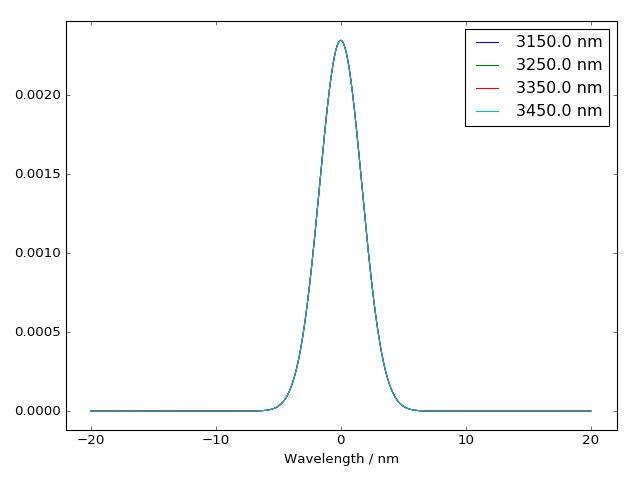

(<matplotlib.figure.Figure at 0x7ffb44547150>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ffb444a3e90>)

In [165]:
plot_lineshape(self)

In [161]:
self.spectrum_df['x_axes','wavelength'].values[-1]

3450.0